In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Author: Milan Ondrasovic <milan.ondrasovic@gmail.com>

import math
from typing import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image, ImageStat, ImageOps

plt.style.use('tableau-colorblind10')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

%load_ext autoreload
%autoreload 2

In [ ]:
my_model_file_path = "../model_siamfc.pth"
my_model = torch.load(my_model_file_path, map_location=torch.device('cpu'))

new_model_file_path = "../siamfc_alexnet_e50.pth"
new_model = torch.load(new_model_file_path, map_location=torch.device('cpu'))

len(my_model), len(new_model)

In [ ]:
for my_item, new_item in zip(my_model.items(), new_model.items()):
    print("*" * 80)
    print(f"M: {my_item[0]} {list(my_item[1].shape)}")
    print(f"N: {new_item[0]} {list(new_item[1].shape)}")

In [ ]:
new_model_data = OrderedDict()

for my_item, new_item in zip(my_model.items(), new_model.items()):
    new_model_data[my_item[0]] = new_item[1]

for item in new_model_data.items():
    print(f"{item[0]} {list(item[1].shape)}")

torch.save(new_model_data, "../model_combined.pth")

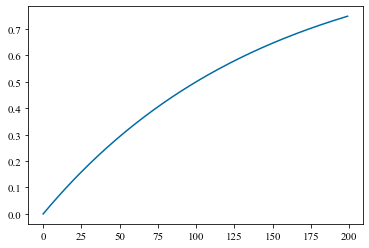

In [12]:
time_point = 100
target_weight = 0.5

decay = (1 / time_point) * np.log(1 - target_weight)

xs = np.arange(0, 200)
ys = 1 - np.exp(decay * xs)

plt.plot(xs, ys)
plt.show()